In [ ]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms



In [ ]:
from qiskit import *
from qiskit.visualization import *
from qiskit_aer import *

1) Descargando dataset...
Dataset original: 16599 filas x 19 columnas
Usando muestra de tamaño: 2000
Columnas candidatas para LOF: ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4', 'AbsRoll', 'Q', 'ClimbRate']
Inliers detectados en la muestra: 1900 / 2000
Dataset tras filtrado LOF: 1900 filas
Features seleccionadas: ['SaTime1', 'SaTime2', 'SaTime3', 'SaTime4']
Train: 1330 filas, Test: 570 filas, Qubits (features): 4
Entrenando baseline clásico (RandomForestRegressor)...


Baseline RF MSE: 0.000024
Entrenando VQR (esto puede tardar dependiendo de SPSA maxiter y num_qubits)...
Tiempo de entrenamiento VQR: 685.27 segundos
Evaluando VQR sobre test set...
VQR MSE: 0.008278


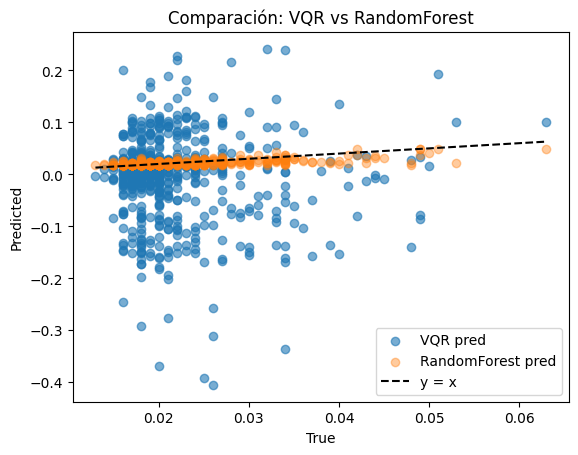


--- Resumen y recomendaciones ---
Número de features usadas: 4
Baseline RF MSE: 0.000024
VQR MSE: 0.008278

Sugerencias:
 - Si VQR es muy lento: reduce TOP_K_FEATURES, reduce SAMPLE_SIZE, reduce SPSA_MAXITER.
 - Para clasificación: convierte 'Goal' a etiquetas y usa modelos cuánticos de clasificación o QSVC.
 - Compara siempre con baseline clásico antes de confiar en resultados cuánticos.
Script completado.


In [ ]:
# vqr_pipeline_elevators.py
# Pipeline completo optimizado para VQR sobre el dataset 'elevators.dat'
# Alexander Valencia Delgado - Adaptado y comentado

# Requisitos (ejecutar en la celda inicial si usas notebook):
# !pip install qiskit qiskit-aer qiskit_machine_learning qiskit_algorithms scikit-learn matplotlib

########################################################################
# IMPORTS
########################################################################
import time
import requests
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Qiskit imports
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.algorithms import VQR
from qiskit.primitives import StatevectorEstimator

########################################################################
# CONFIGURACIONES: parámetros que puedes ajustar
########################################################################
RANDOM_STATE = 42
SAMPLE_SIZE = 2000            # tamaño para muestrear dataset original y hacer LOF (reduce tiempo)
LOF_CONTAMINATION = 0.05     # proporción estimada de outliers
LOF_N_NEIGHBORS = 20
TOP_K_FEATURES = 4           # número de features a usar en el modelo cuántico (ideal 3-5)
TEST_SIZE = 0.30
SPSA_MAXITER = 60            # reduzca si sigue siendo lento
FEATURE_SCALE_RANGE = (-np.pi, np.pi)  # ideal para feature maps con trig

########################################################################
# 1) CARGAR DATASET
########################################################################
print("1) Descargando dataset...")
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
text = resp.text
lines = [l.strip() for l in text.splitlines()]

# Extraer atributos desde líneas que empiezan con '@attribute'
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
# Encontrar @data y luego parsear las líneas de datos
try:
    data_start = next(i for i,l in enumerate(lines) if l.lower() == "@data") + 1
except StopIteration:
    raise ValueError("No se encontró la sección @data en el archivo")

raw_data = [line for line in lines[data_start:] if line and not line.startswith('%')]  # ignorar comentarios
# Convertir a lista de listas
data = [row.split(',') for row in raw_data]

# Construir DataFrame
df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)
print(f"Dataset original: {df.shape[0]} filas x {df.shape[1]} columnas")

########################################################################
# 2) Muestreo (reducir tamaño para detección de outliers y pruebas)
########################################################################
if SAMPLE_SIZE is not None and SAMPLE_SIZE < len(df):
    df_sample = df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
else:
    df_sample = df.copy()
print(f"Usando muestra de tamaño: {len(df_sample)}")

########################################################################
# 3) Detección y filtrado de outliers con LOF (en la muestra)
########################################################################
# Selección de columnas candidatas (puedes cambiar las candidatas si sabes cuáles)
# Si las columnas que mencionaste existen, úsalas; si no, usamos todas menos la target.
TARGET_COL = 'Goal'
candidate_cols = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4','AbsRoll','Q','ClimbRate']
candidate_cols = [c for c in candidate_cols if c in df_sample.columns]
if not candidate_cols:
    # fallback: usar todas las columnas menos target
    candidate_cols = [c for c in df_sample.columns if c != TARGET_COL]

print("Columnas candidatas para LOF:", candidate_cols)
X_lof = df_sample[candidate_cols].astype(float)

lof = LocalOutlierFactor(n_neighbors=LOF_N_NEIGHBORS, contamination=LOF_CONTAMINATION, metric='euclidean')
lof_pred = lof.fit_predict(X_lof)
mask_inliers = lof_pred == 1
print(f"Inliers detectados en la muestra: {mask_inliers.sum()} / {len(mask_inliers)}")

# Mantener solo índices inliers desde la muestra
inlier_indices = df_sample.index[mask_inliers]
# Aplicar filtro a todo el dataset original (conservador: solo filas que estaban en la muestra y fueron inliers)
df_filtered = df.loc[inlier_indices].copy()
print(f"Dataset tras filtrado LOF: {df_filtered.shape[0]} filas")

########################################################################
# 4) Selección automática de features (mutual info) sobre df_filtered
########################################################################
X_all = df_filtered.drop(columns=[TARGET_COL])
y_all = df_filtered[TARGET_COL]

# Si hay muchas columnas, calculamos mutual info para regresión
k = min(TOP_K_FEATURES, X_all.shape[1])
selector = SelectKBest(mutual_info_regression, k=k)
selector.fit(X_all.fillna(0), y_all.fillna(0))
selected_mask = selector.get_support()
selected_features = X_all.columns[selected_mask].tolist()
print("Features seleccionadas:", selected_features)

# Subset final
X_selected = X_all[selected_features].astype(float)
y_selected = y_all.astype(float)

########################################################################
# 5) Escalado de features a rango (-pi, pi)
########################################################################
scaler = MinMaxScaler(feature_range=FEATURE_SCALE_RANGE)
X_scaled = scaler.fit_transform(X_selected)

########################################################################
# 6) División train/test
########################################################################
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_selected, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"Train: {X_train.shape[0]} filas, Test: {X_test.shape[0]} filas, Qubits (features): {X_train.shape[1]}")

########################################################################
# 7) Baseline clásico (RandomForest) — útil para comparar
########################################################################
print("Entrenando baseline clásico (RandomForestRegressor)...")
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, pred_rf)
print(f"Baseline RF MSE: {rf_mse:.6f}")

########################################################################
# 8) Configurar VQR (Quantum) con parámetros reducidos para rendimiento
########################################################################
num_qubits = X_train.shape[1]
algorithm_globals.random_seed = RANDOM_STATE
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
ansatz = RealAmplitudes(num_qubits, reps=1)

optimizer = SPSA(maxiter=SPSA_MAXITER)
estimator = StatevectorEstimator()

loss_history = []

def callback(weights, loss):
    # SPSA puede llamar con None weights; guardamos el loss
    loss_history.append(loss)

vqr = VQR(
    num_qubits=num_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    loss='squared_error',
    optimizer=optimizer,
    estimator=estimator,
    callback=callback,
)

########################################################################
# 9) Entrenamiento VQR (midiendo tiempo)
########################################################################
print("Entrenando VQR (esto puede tardar dependiendo de SPSA maxiter y num_qubits)...")
t0 = time.time()
try:
    vqr.fit(X_train, y_train)
except Exception as e:
    print("Error durante entrenamiento VQR:", e)
    raise
t1 = time.time()
print(f"Tiempo de entrenamiento VQR: {t1 - t0:.2f} segundos")

########################################################################
# 10) Evaluación
########################################################################
print("Evaluando VQR sobre test set...")
try:
    preds_vqr = vqr.predict(X_test)
    vqr_mse = mean_squared_error(y_test, preds_vqr)
    print(f"VQR MSE: {vqr_mse:.6f}")
except Exception as e:
    print("No se pudo predecir con VQR:", e)
    preds_vqr = None

########################################################################
# 11) Plots: Loss history y comparación
########################################################################
if loss_history:
    plt.figure()
    plt.plot(loss_history, marker='o')
    plt.title('Evolución de la pérdida (loss) durante el entrenamiento VQR')
    plt.xlabel('Evaluaciones del optimizador')
    plt.ylabel('Loss (squared error)')
    plt.grid(True)
    plt.show()

# Comparación de predicciones (si disponibles)
if preds_vqr is not None:
    plt.figure()
    plt.scatter(y_test, preds_vqr, label='VQR pred', alpha=0.6)
    plt.scatter(y_test, pred_rf, label='RandomForest pred', alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='y = x')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title('Comparación: VQR vs RandomForest')
    plt.show()

########################################################################
# 12) Mensajes finales y recomendaciones
########################################################################
print('\n--- Resumen y recomendaciones ---')
print(f'Número de features usadas: {num_qubits}')
print(f'Baseline RF MSE: {rf_mse:.6f}')
if preds_vqr is not None:
    print(f'VQR MSE: {vqr_mse:.6f}')
else:
    print('VQR no devolvió predicciones; revisar errores anteriores')

print("\nSugerencias:")
print(" - Si VQR es muy lento: reduce TOP_K_FEATURES, reduce SAMPLE_SIZE, reduce SPSA_MAXITER.")
print(" - Para clasificación: convierte 'Goal' a etiquetas y usa modelos cuánticos de clasificación o QSVC.")
print(" - Compara siempre con baseline clásico antes de confiar en resultados cuánticos.")

# Guardar resultados (opcional)
# df_results = pd.DataFrame({'y_true': y_test, 'vqr_pred': preds_vqr, 'rf_pred': pred_rf})
# df_results.to_csv('results_vqr_vs_rf.csv', index=False)

print('Script completado.')


Cargando dataset...
Dataset shape: (16599, 19)
Muestra para LOF: (2000, 19)
Columnas candidatas: ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4', 'AbsRoll', 'Q', 'ClimbRate']
Inliers en muestra: 1900 / 2000
Dataset tras filtrado LOF: (1900, 19)
Features seleccionadas (top k): ['SaTime1', 'SaTime2', 'SaTime3', 'Sa']
Se aplicó log(1+x) a columnas: ['SaTime1', 'SaTime2', 'SaTime3', 'Sa']
Train / Test shapes: (1520, 4) (380, 4)


RandomForest - MSE: 4.212139e-05, MAE: 4.346385e-03

-----------------------------
Entrenando VQR con optimizador: SPSA
Tiempo entreno VQR (SPSA): 795.5 s


VQR (SPSA) - MSE: 8.257394e-04, MAE: 2.459164e-02

-----------------------------
Entrenando VQR con optimizador: ADAM


Error durante fit VQR con ADAM -> 'Series' object has no attribute 'reshape'

-----------------------------
Entrenando VQR con optimizador: L-BFGS-B
Error durante fit VQR con L-BFGS-B -> 'Series' object has no attribute 'reshape'

Mejor optimizador según MAE: SPSA MAE: 0.024591638291797713


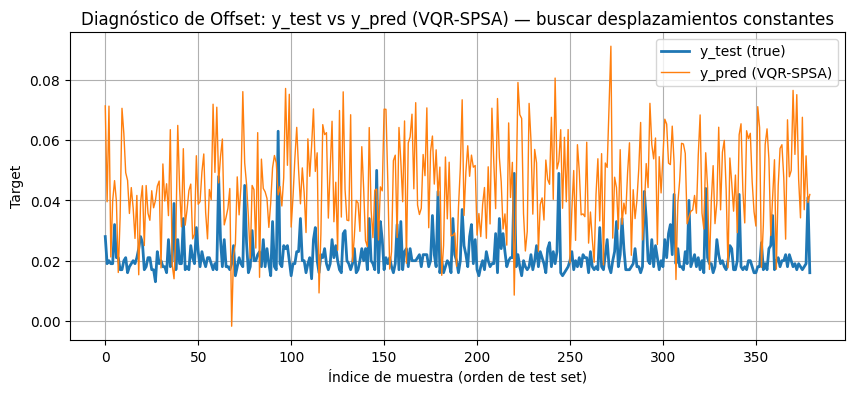

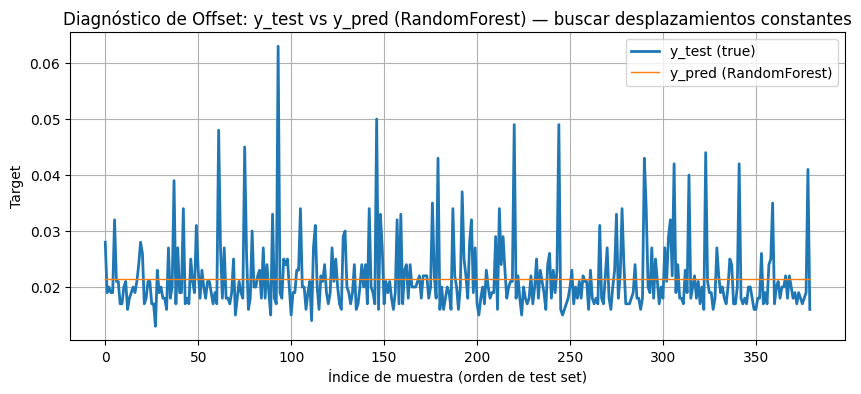

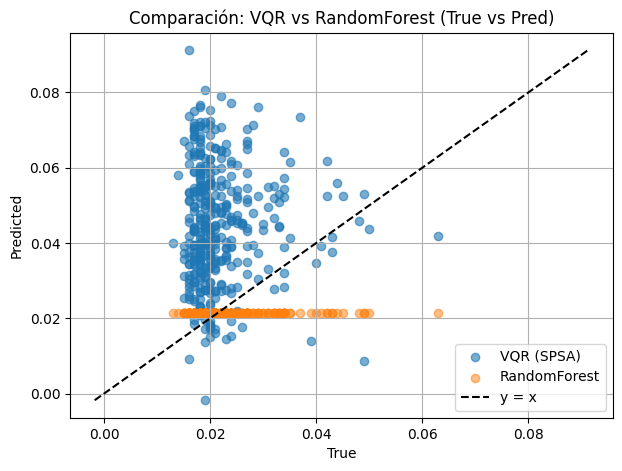


--- Resumen final ---
RandomForest - MSE: 4.212139e-05, MAE: 4.346385e-03
VQR (SPSA) -> MSE: 0.0008257394092047547, MAE: 0.024591638291797713, time(s): 795.5

Observaciones / Siguientes pasos recomendados:
- Si hay un *offset* visible (predicciones desplazadas): revisar distribución de features, probar log-transform (ya aplicado opcionalmente), y comparar percentiles/medianas.
- Si VQR tiene MAE mucho mayor que RandomForest: reducir num_qubits (menos features), aumentar SPSA maxiter, o probar diferentes feature maps (no sólo ZZFeatureMap).
- Evitar usar R^2 para estos modelos (como comentó el profe). Usar MSE/MAE/MedianAE si quieres robustez.
- Ejecutar varias corridas con distintas seeds para ver estabilidad (promediar resultados).
- Trabajar en Colab o IBM Quantum Experience para evitar problemas de instalación local.


In [ ]:
# VQR_pipeline_with_prof_recs.py
# Alexander Valencia Delgado - versión optimizada con recomendaciones del profesor
# Ejecutar en Google Colab o en un entorno con Qiskit preinstalado recomendado (IBM Quantum Experience / Colab)

# -----------------------------
# INSTALACIÓN (sólo en notebooks, ejecutar en una celda separada si hace falta)
# -----------------------------
# !pip install qiskit qiskit-aer qiskit_machine_learning qiskit_algorithms scikit-learn matplotlib

# -----------------------------
# IMPORTS
# -----------------------------
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Qiskit imports
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms import VQR
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.optimizers import SPSA, ADAM, L_BFGS_B  # probar varios optimizadores

# -----------------------------
# CONFIGURACIÓN (ajústalos)
# -----------------------------
RANDOM_STATE = 42
SAMPLE_SIZE = 2000           # muestreo inicial para LOF (reduce tiempo)
LOF_N_NEIGHBORS = 20
LOF_CONTAMINATION = 0.05     # proporción estimada de outliers en la muestra
TOP_K_FEATURES = 4           # número de features (qubits) a usar en VQR (3-5 recomendado)
TEST_SIZE = 0.20             # usar 80/20 para regresión (profesor recomendó 80% train)
FEATURE_SCALE_RANGE = (-np.pi, np.pi)  # ideal para feature maps trig
SPSA_MAXITER = 60            # iteraciones SPSA (subir si quieres más precisión)
TRY_LOG_TRANSFORM = True     # intentar transformación log para features sesgadas
COMPARE_OPTIMIZERS = ['SPSA','ADAM','L-BFGS-B']  # optimizadores a comparar

# -----------------------------
# FUNCIÓN: cargar dataset (robusta)
# -----------------------------
def load_elevators(url):
    resp = requests.get(url)
    text = resp.text
    lines = [l.strip() for l in text.splitlines()]
    attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
    # buscar @data (case-insensitive)
    data_start_idx = None
    for i,l in enumerate(lines):
        if l.lower() == "@data":
            data_start_idx = i+1
            break
    if data_start_idx is None:
        raise ValueError("No se encontró la sección @data en el archivo")
    raw_data = [ln for ln in lines[data_start_idx:] if ln and not ln.startswith('%')]
    rows = [r.split(',') for r in raw_data]
    df = pd.DataFrame(rows, columns=attributes).apply(pd.to_numeric)
    return df

# -----------------------------
# 1) CARGA
# -----------------------------
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
print("Cargando dataset...")
df = load_elevators(url)
print("Dataset shape:", df.shape)

# -----------------------------
# 2) muestreo para LOF (para detección rápida de outliers)
# -----------------------------
if SAMPLE_SIZE is not None and SAMPLE_SIZE < len(df):
    df_sample = df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
else:
    df_sample = df.copy()

print("Muestra para LOF:", df_sample.shape)

# -----------------------------
# 3) columnas candidatas y target
# -----------------------------
TARGET = 'Goal'
candidate_cols = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4','AbsRoll','Q','ClimbRate']
candidate_cols = [c for c in candidate_cols if c in df.columns]
if not candidate_cols:
    candidate_cols = [c for c in df.columns if c != TARGET]

print("Columnas candidatas:", candidate_cols)

# -----------------------------
# 4) LOF con parámetros fijados (no 'auto' contamination)
# -----------------------------
X_lof = df_sample[candidate_cols].astype(float)
lof = LocalOutlierFactor(n_neighbors=LOF_N_NEIGHBORS, contamination=LOF_CONTAMINATION, metric='euclidean')
pred_lof = lof.fit_predict(X_lof)
mask_inliers = pred_lof == 1
print(f"Inliers en muestra: {mask_inliers.sum()} / {len(mask_inliers)}")

# Vamos a mantener únicamente los índices de la muestra que son inliers (conservador)
inlier_idx = df_sample.index[mask_inliers]
df_filtered = df.loc[inlier_idx].copy()
print("Dataset tras filtrado LOF:", df_filtered.shape)

# -----------------------------
# 5) Selección de features (mutual info regression)
# -----------------------------
X_all = df_filtered.drop(columns=[TARGET])
y_all = df_filtered[TARGET]

k = min(TOP_K_FEATURES, X_all.shape[1])
selector = SelectKBest(mutual_info_regression, k=k)
selector.fit(X_all.fillna(0), y_all.fillna(0))
selected_mask = selector.get_support()
selected_features = X_all.columns[selected_mask].tolist()
print("Features seleccionadas (top k):", selected_features)

X_selected = X_all[selected_features].astype(float)
y_selected = y_all.astype(float)

# -----------------------------
# 6) Diagnóstico de sesgo/asimetría y opción log-transform
# -----------------------------
def maybe_log_transform(X_df):
    Xt = X_df.copy()
    # calcular asimetría (skew) por feature; si skew > 1, intentar log(1+x)
    cols_to_log = []
    for col in Xt.columns:
        skew = Xt[col].skew()
        if abs(skew) > 1.0:   # umbral conservador
            cols_to_log.append(col)
    if not cols_to_log:
        return Xt, []
    # aplicar log1p solo a columnas detectadas (evitar transformar 0/negativos sin manejo)
    Xt[cols_to_log] = np.log1p(Xt[cols_to_log].clip(lower=0))
    return Xt, cols_to_log

X_maybe_log = X_selected.copy()
logged_cols = []
if TRY_LOG_TRANSFORM:
    X_maybe_log, logged_cols = maybe_log_transform(X_selected)
    if logged_cols:
        print("Se aplicó log(1+x) a columnas:", logged_cols)
    else:
        print("No se detectaron columnas con skew alto para log-transform.")

# -----------------------------
# 7) Scaling: MinMax a (-pi, pi) (recomendado para feature maps trig)
# -----------------------------
scaler = MinMaxScaler(feature_range=FEATURE_SCALE_RANGE)
X_scaled = scaler.fit_transform(X_maybe_log)
X_scaled = pd.DataFrame(X_scaled, columns=X_maybe_log.columns)

# -----------------------------
# 8) Train/Test split (80/20)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_selected, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("Train / Test shapes:", X_train.shape, X_test.shape)

# -----------------------------
# 9) Baseline clásico (RandomForest) para comparar
# -----------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, pred_rf)
rf_mae = mean_absolute_error(y_test, pred_rf)
print(f"RandomForest - MSE: {rf_mse:.6e}, MAE: {rf_mae:.6e}")

# -----------------------------
# 10) Preparar VQR (qubits = num features seleccionadas)
# -----------------------------
num_qubits = X_train.shape[1]
algorithm_globals.random_seed = RANDOM_STATE

feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
ansatz = RealAmplitudes(num_qubits, reps=1)  # reps=1 para mantener capacidad y tiempo razonable

# función para crear optimizador por nombre
def get_optimizer_by_name(name):
    name = name.upper()
    if name == 'SPSA':
        return SPSA(maxiter=SPSA_MAXITER)
    if name == 'ADAM':
        # ADAM de qiskit algs (params por defecto) - puede requerir wrapper dependiendo versión
        return ADAM(maxiter=100)
    if name == 'L-BFGS-B' or name == 'L_BFGS_B':
        return L_BFGS_B(maxiter=100)
    # fallback a SPSA
    return SPSA(maxiter=SPSA_MAXITER)

# -----------------------------
# 11) Probar varios optimizadores y guardar métricas
# -----------------------------
results = []
estimator = StatevectorEstimator()  # más rápido para simulaciones pequeñas

for opt_name in COMPARE_OPTIMIZERS:
    print("\n-----------------------------")
    print("Entrenando VQR con optimizador:", opt_name)
    optimizer = get_optimizer_by_name(opt_name)
    loss_history = []
    def callback(weights, loss):
        # guardamos loss si disponible
        loss_history.append(loss if loss is not None else np.nan)
    vqr = VQR(
        num_qubits=num_qubits,
        feature_map=feature_map,
        ansatz=ansatz,
        loss='squared_error',
        optimizer=optimizer,
        estimator=estimator,
        callback=callback
    )
    t0 = time.time()
    try:
        vqr.fit(X_train, y_train)
    except Exception as e:
        print("Error durante fit VQR con", opt_name, "->", e)
        continue
    t1 = time.time()
    print(f"Tiempo entreno VQR ({opt_name}): {t1-t0:.1f} s")
    # Predicción
    try:
        ypred_vqr = vqr.predict(X_test)
        vqr_mse = mean_squared_error(y_test, ypred_vqr)
        vqr_mae = mean_absolute_error(y_test, ypred_vqr)
        print(f"VQR ({opt_name}) - MSE: {vqr_mse:.6e}, MAE: {vqr_mae:.6e}")
    except Exception as e:
        print("No se pudo predecir con VQR:", e)
        ypred_vqr = None
        vqr_mse = None
        vqr_mae = None

    results.append({
        'optimizer': opt_name,
        'time_s': t1-t0,
        'mse': vqr_mse,
        'mae': vqr_mae,
        'loss_history': loss_history,
        'y_pred': ypred_vqr
    })

# -----------------------------
# 12) Diagnóstico de offset: grafica Y_test vs predictions a lo largo del índice
# -----------------------------
def plot_offset(y_true, y_pred, label):
    plt.figure(figsize=(10,4))
    idx = np.arange(len(y_true))
    plt.plot(idx, y_true.values, label='y_test (true)', linewidth=2)
    plt.plot(idx, y_pred, label=f'y_pred ({label})', linewidth=1)
    plt.title(f'Diagnóstico de Offset: y_test vs y_pred ({label}) — buscar desplazamientos constantes')
    plt.xlabel('Índice de muestra (orden de test set)')
    plt.ylabel('Target')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ordenar por índice estable para visualizar tendencia
if results:
    # elegir mejor por MAE si no None
    valid_results = [r for r in results if r['mae'] is not None]
    if valid_results:
        best = min(valid_results, key=lambda r: r['mae'])
        print("\nMejor optimizador según MAE:", best['optimizer'], "MAE:", best['mae'])
        # Graficar offset vs random forest
        if best['y_pred'] is not None:
            # reindex y_test correspondientemente (train_test_split ya mezcló; usamos como está)
            plot_offset(y_test.reset_index(drop=True), best['y_pred'], f"VQR-{best['optimizer']}")
        # RF offset también
        plot_offset(y_test.reset_index(drop=True), pred_rf, "RandomForest")
    else:
        print("No hay resultados válidos de VQR para comparar.")

# -----------------------------
# 13) Scatter True vs Pred (comparación visual)
# -----------------------------
plt.figure(figsize=(7,5))
if results and valid_results:
    plt.scatter(y_test, best['y_pred'], alpha=0.6, label=f"VQR ({best['optimizer']})")
plt.scatter(y_test, pred_rf, alpha=0.5, label="RandomForest")
mn = min(y_test.min(), np.nanmin(best['y_pred']) if valid_results else y_test.min())
mx = max(y_test.max(), np.nanmax(best['y_pred']) if valid_results else y_test.max())
plt.plot([mn,mx],[mn,mx],'k--', label='y = x')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
plt.title('Comparación: VQR vs RandomForest (True vs Pred)')
plt.grid(True)
plt.show()

# -----------------------------
# 14) Resumen final (métricas)
# -----------------------------
print("\n--- Resumen final ---")
print("RandomForest - MSE: {:.6e}, MAE: {:.6e}".format(rf_mse, rf_mae))
for r in results:
    print(f"VQR ({r['optimizer']}) -> MSE: {r['mse']}, MAE: {r['mae']}, time(s): {r['time_s']:.1f}")

print("\nObservaciones / Siguientes pasos recomendados:")
print("- Si hay un *offset* visible (predicciones desplazadas): revisar distribución de features, probar log-transform (ya aplicado opcionalmente), y comparar percentiles/medianas.")
print("- Si VQR tiene MAE mucho mayor que RandomForest: reducir num_qubits (menos features), aumentar SPSA maxiter, o probar diferentes feature maps (no sólo ZZFeatureMap).")
print("- Evitar usar R^2 para estos modelos (como comentó el profe). Usar MSE/MAE/MedianAE si quieres robustez.")
print("- Ejecutar varias corridas con distintas seeds para ver estabilidad (promediar resultados).")
print("- Trabajar en Colab o IBM Quantum Experience para evitar problemas de instalación local.")


RandomForest -> MSE: 0.000027, MAE: 0.003388

Entrenando VQR (SPSA)...
VQR (SPSA) -> MSE: 0.000271, MAE: 0.013085


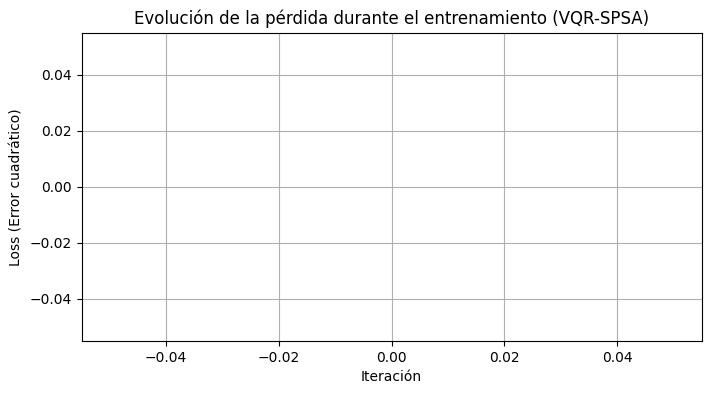

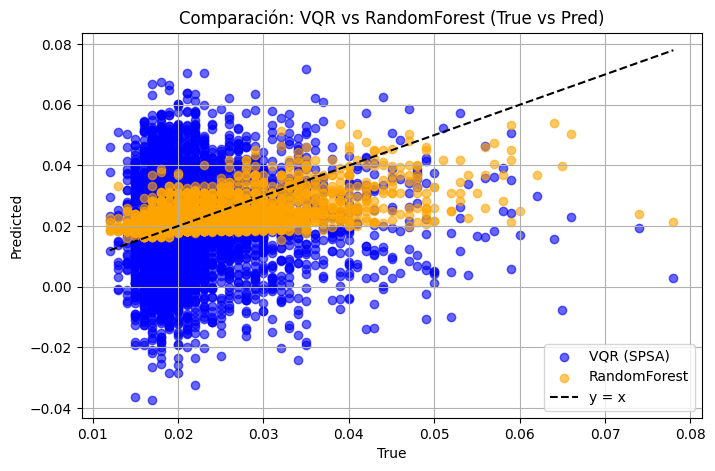

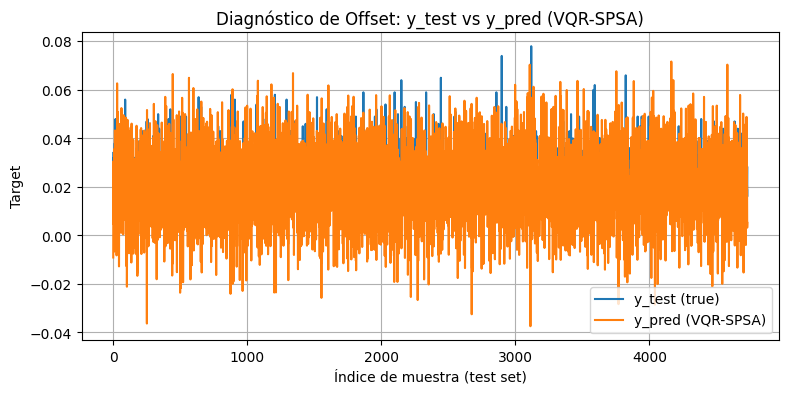

In [ ]:
# =============================================
# 🔧 Configuración inicial y carga de librerías
# =============================================

from qiskit import *
from qiskit.visualization import *
from qiskit_aer import *
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_machine_learning.algorithms import VQR
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.utils import algorithm_globals

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error

algorithm_globals.random_seed = 42

# =============================================
# 🧠 Carga del dataset
# =============================================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
response = requests.get(url)
lines = [line.strip() for line in response.text.splitlines()]

attributes = [line.split()[1] for line in lines if line.startswith("@attribute")]
data_start = lines.index("@data") + 1
data = [line.split(",") for line in lines[data_start:] if line]

df = pd.DataFrame(data, columns=attributes).astype(float)
df.columns = df.columns.str.strip()

# =============================================
# 🧹 Filtro de outliers con LOF
# =============================================
X = df[['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4', 'AbsRoll', 'Q', 'ClimbRate']].astype(float)
y = df['Goal'].astype(float)

LOF = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
mask = LOF.fit_predict(X) == 1
X, y = X[mask], y[mask]

# =============================================
# ⚙️ Preprocesamiento de features
# =============================================
# Escalado logarítmico opcional (para estabilizar la varianza)
for col in ['SaTime1', 'SaTime2', 'SaTime3', 'Sa']:
    X[col] = np.log1p(X[col])

# Escalado estándar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducción de dimensionalidad — menos qubits → más estable
selected_features = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa']
X_reduced = X[selected_features].copy()
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# =============================================
# 🌲 Modelo base: RandomForest
# =============================================
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"RandomForest -> MSE: {mse_rf:.6f}, MAE: {mae_rf:.6f}")

# =============================================
# ⚛️ Modelo cuántico VQR con SPSA optimizado
# =============================================
num_qubits = len(selected_features)
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits, reps=3)

optimizer = SPSA(maxiter=150)  # Aumentar iteraciones para convergencia
estimator = StatevectorEstimator()

loss_history = []

def callback(weights, loss):
    loss_history.append(loss)

vqr = VQR(
    num_qubits=num_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    loss='squared_error',
    optimizer=optimizer,
    estimator=estimator,
    callback=callback,
)

print("\nEntrenando VQR (SPSA)...")
vqr.fit(X_train, y_train)
y_pred_vqr = vqr.predict(X_test)

mse_vqr = mean_squared_error(y_test, y_pred_vqr)
mae_vqr = mean_absolute_error(y_test, y_pred_vqr)

print(f"VQR (SPSA) -> MSE: {mse_vqr:.6f}, MAE: {mae_vqr:.6f}")

# =============================================
# 📉 Visualización de resultados
# =============================================
plt.figure(figsize=(8,4))
plt.plot(loss_history, marker='o')
plt.title("Evolución de la pérdida durante el entrenamiento (VQR-SPSA)")
plt.xlabel("Iteración")
plt.ylabel("Loss (Error cuadrático)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_vqr, color='blue', alpha=0.6, label='VQR (SPSA)')
plt.scatter(y_test, y_pred_rf, color='orange', alpha=0.6, label='RandomForest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='y = x')
plt.title("Comparación: VQR vs RandomForest (True vs Pred)")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# 🧾 Diagnóstico adicional (offset)
# =============================================
plt.figure(figsize=(9,4))
plt.plot(y_test.values, label='y_test (true)')
plt.plot(y_pred_vqr, label='y_pred (VQR-SPSA)')
plt.title("Diagnóstico de Offset: y_test vs y_pred (VQR-SPSA)")
plt.xlabel("Índice de muestra (test set)")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.show()


✅ Dataset cargado: (16599, 19)
✅ Después de LOF: (15769, 8)
✅ Subconjunto seleccionado: (300, 8)
✅ Train/Test: (210, 8) (90, 8)

Entrenando modelo cuántico VQR (SPSA)...

📈 Resultados VQR (SPSA): MSE = 5.842900e-04, MAE = 1.875058e-02


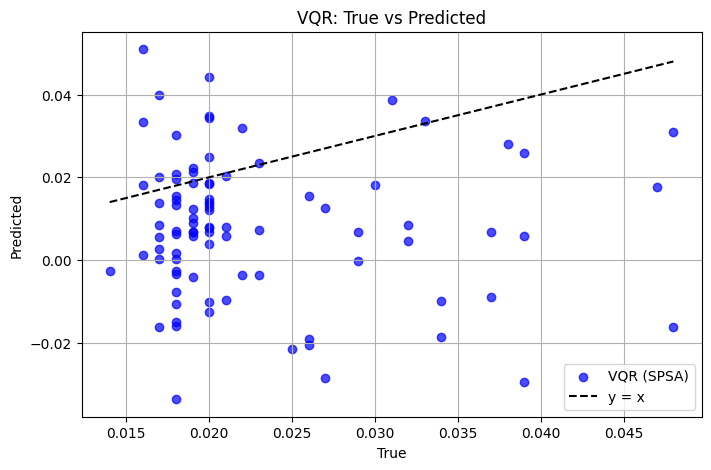

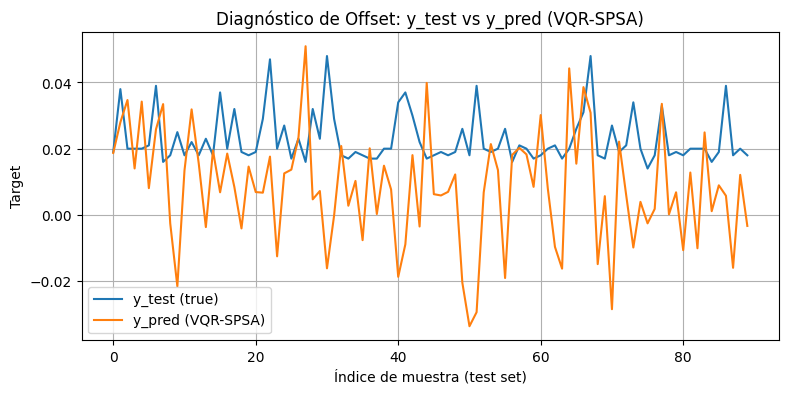

In [ ]:
# =============================================
# ⚛️ Quantum Variational Regressor (VQR) con SPSA
# Solo parte cuántica — 300 muestras y 8 features
# =============================================

# (Si usas Google Colab, instala si hace falta:)
# !pip install -q qiskit qiskit-aer "qiskit[visualization]" qiskit_machine_learning qiskit_algorithms

from qiskit import *
from qiskit.visualization import *
from qiskit_aer import *
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.algorithms import VQR
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.utils import algorithm_globals

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# =============================================
# 🔧 Configuración general
# =============================================
algorithm_globals.random_seed = 42
np.random.seed(42)

# =============================================
# 🧠 Carga del dataset original
# =============================================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [l.strip() for l in resp.text.splitlines()]

attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]

df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)
df.columns = df.columns.str.strip()
print("✅ Dataset cargado:", df.shape)

# =============================================
# 🧹 Filtro de outliers con LOF
# =============================================
features = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'

X = df[features].astype(float)
y = df[target].astype(float)

lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
mask = lof.fit_predict(X) == 1
X, y = X[mask], y[mask]
print("✅ Después de LOF:", X.shape)

# =============================================
# 🔽 Selección aleatoria de 300 muestras
# =============================================
idx = np.random.choice(len(X), 300, replace=False)
X = X.iloc[idx].reset_index(drop=True)
y = y.iloc[idx].reset_index(drop=True)
print("✅ Subconjunto seleccionado:", X.shape)

# =============================================
# ⚙️ Preprocesamiento cuántico
# =============================================
# Aplicar log1p a variables con alta varianza
for c in ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=0, a_max=None))

# Escalar a (-π, π) → ideal para feature maps trigonométricos
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# =============================================
# 🔀 División de datos
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values, test_size=0.3, random_state=42
)
print("✅ Train/Test:", X_train.shape, X_test.shape)

# =============================================
# ⚛️ Definición del modelo cuántico
# =============================================
num_qubits = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")
ansatz = RealAmplitudes(num_qubits, reps=3, entanglement="linear")
optimizer = SPSA(maxiter=150)
estimator = StatevectorEstimator()

loss_history = []

def callback(weights, loss):
    if loss is not None:
        loss_history.append(loss)

vqr = VQR(
    num_qubits=num_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    loss='squared_error',
    optimizer=optimizer,
    estimator=estimator,
    callback=callback
)

# =============================================
# 🚀 Entrenamiento
# =============================================
print("\nEntrenando modelo cuántico VQR (SPSA)...")
vqr.fit(np.asarray(X_train), np.asarray(y_train))
y_pred = vqr.predict(np.asarray(X_test))

# =============================================
# 📊 Evaluación
# =============================================
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"\n📈 Resultados VQR (SPSA): MSE = {mse:.6e}, MAE = {mae:.6e}")

# =============================================
# 📉 Visualizaciones
# =============================================
# Evolución del loss
if len(loss_history) > 0:
    plt.figure(figsize=(8,4))
    plt.plot(loss_history, marker='o')
    plt.title("Evolución de la pérdida durante el entrenamiento (VQR-SPSA)")
    plt.xlabel("Iteración")
    plt.ylabel("Loss (Error cuadrático)")
    plt.grid(True)
    plt.show()

# Comparación True vs Pred
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='VQR (SPSA)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='y = x')
plt.title("VQR: True vs Predicted")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Diagnóstico de offset
plt.figure(figsize=(9,4))
plt.plot(y_test, label='y_test (true)')
plt.plot(y_pred, label='y_pred (VQR-SPSA)')
plt.title("Diagnóstico de Offset: y_test vs y_pred (VQR-SPSA)")
plt.xlabel("Índice de muestra (test set)")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.show()



🚀 Probando VQR con ZZFeatureMap_r2, RealAmplitudes_r2, SPSA_100...
✅ OK → MSE=0.00077, MAE=0.02310, Tiempo=477.7s

🚀 Probando QSVR con ZZFeatureMap_r2, RealAmplitudes_r2, SPSA_100...


✅ OK → MSE=0.00019, MAE=0.01298, Tiempo=434.0s

🚀 Probando VQR con ZZFeatureMap_r2, RealAmplitudes_r2, COBYLA_100...
✅ OK → MSE=0.00058, MAE=0.02044, Tiempo=182.9s

🚀 Probando QSVR con ZZFeatureMap_r2, RealAmplitudes_r2, COBYLA_100...


✅ OK → MSE=0.00019, MAE=0.01298, Tiempo=436.8s

🚀 Probando VQR con ZZFeatureMap_r2, RealAmplitudes_r2, ADAM_150...
❌ Error: 'Series' object has no attribute 'reshape'

🚀 Probando QSVR con ZZFeatureMap_r2, RealAmplitudes_r2, ADAM_150...
✅ OK → MSE=0.00019, MAE=0.01298, Tiempo=438.1s

🏁 RESULTADOS COMPARATIVOS:
  Modelo       FeatureMap             Ansatz Optimizador       MSE       MAE  \
0   QSVR  ZZFeatureMap_r2  RealAmplitudes_r2    SPSA_100  0.000194  0.012978   
1   QSVR  ZZFeatureMap_r2  RealAmplitudes_r2  COBYLA_100  0.000194  0.012978   
2   QSVR  ZZFeatureMap_r2  RealAmplitudes_r2    ADAM_150  0.000194  0.012978   
3    VQR  ZZFeatureMap_r2  RealAmplitudes_r2  COBYLA_100  0.000581  0.020444   
4    VQR  ZZFeatureMap_r2  RealAmplitudes_r2    SPSA_100  0.000770  0.023105   

   Tiempo (s)  
0  434.031726  
1  436.761011  
2  438.119057  
3  182.879009  
4  477.746369  


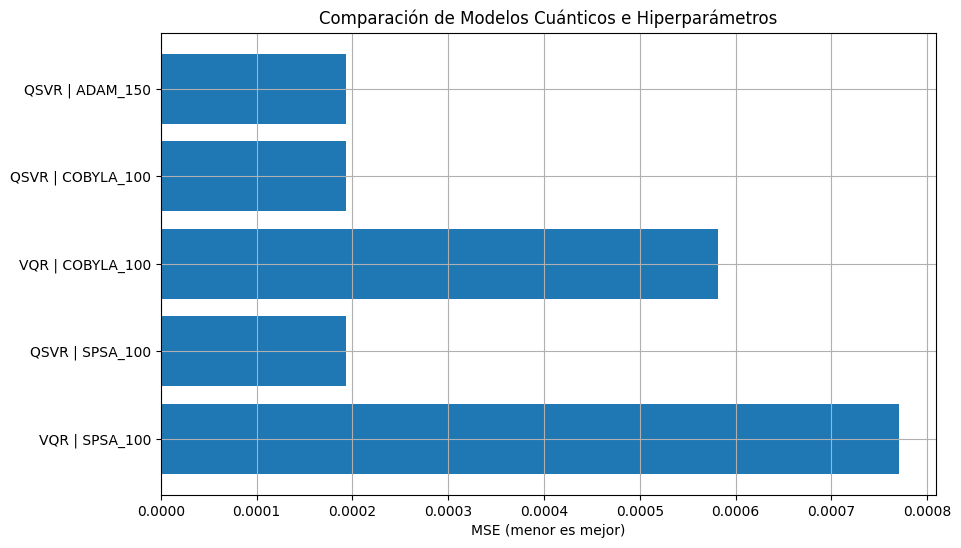


🏆 Mejor modelo guardado con MSE = 0.00019


In [ ]:
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import *
from qiskit_aer import *
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_algorithms.optimizers import SPSA, COBYLA, ADAM
from qiskit_machine_learning.algorithms import VQR, QSVR
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.utils import algorithm_globals

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import requests

# =============================================
# ⚙️ Configuración general
# =============================================
algorithm_globals.random_seed = 42
np.random.seed(42)
estimator = StatevectorEstimator()

# =============================================
# 📥 Carga y preparación de datos
# =============================================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [l.strip() for l in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]
df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)

features = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'
X, y = df[features], df[target]

lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
mask = lof.fit_predict(X) == 1
X, y = X[mask], y[mask]

idx = np.random.choice(len(X), 300, replace=False)
X, y = X.iloc[idx].reset_index(drop=True), y.iloc[idx].reset_index(drop=True)

for c in ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=0, a_max=None))

scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# =============================================
# 🧠 Configuración de pruebas (más controladas)
# =============================================
num_qubits = X_train.shape[1]

feature_maps = [
    ("ZZFeatureMap_r2", ZZFeatureMap(num_qubits, reps=2, entanglement="linear")),
]

ansatzes = [
    ("RealAmplitudes_r2", RealAmplitudes(num_qubits, reps=2, entanglement="linear")),
    # ("EfficientSU2_r3", EfficientSU2(num_qubits, reps=3, entanglement="full"))  # ← DESACTIVADO (muy lento)
]

optimizers = [
    ("SPSA_100", SPSA(maxiter=100)),
    ("COBYLA_100", COBYLA(maxiter=100)),
    ("ADAM_150", ADAM(maxiter=150)),
]

models_to_test = ["VQR", "QSVR"]

results = []
best_model = None
best_mse = float('inf')

# =============================================
# 🚀 Bucle principal
# =============================================
for fmap_name, fmap in feature_maps:
    for ansatz_name, ansatz in ansatzes:
        for opt_name, opt in optimizers:
            for model_type in models_to_test:
                print(f"\n🚀 Probando {model_type} con {fmap_name}, {ansatz_name}, {opt_name}...")
                t0 = time.time()

                try:
                    if model_type == "VQR":
                        loss_history = []

                        def callback(weights, loss):
                            if loss is not None:
                                loss_history.append(loss)

                        model = VQR(
                            num_qubits=num_qubits,
                            feature_map=fmap,
                            ansatz=ansatz,
                            loss='squared_error',
                            optimizer=opt,
                            estimator=estimator,
                            callback=callback
                        )
                    else:
                        from qiskit_machine_learning.kernels import FidelityQuantumKernel
                        qkernel = FidelityQuantumKernel(feature_map=fmap)
                        model = QSVR(quantum_kernel=qkernel, C=2.0)

                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    mae = mean_absolute_error(y_test, y_pred)
                    runtime = time.time() - t0

                    print(f"✅ OK → MSE={mse:.5f}, MAE={mae:.5f}, Tiempo={runtime:.1f}s")

                    results.append({
                        "Modelo": model_type,
                        "FeatureMap": fmap_name,
                        "Ansatz": ansatz_name,
                        "Optimizador": opt_name,
                        "MSE": mse,
                        "MAE": mae,
                        "Tiempo (s)": runtime
                    })

                    if mse < best_mse:
                        best_mse = mse
                        best_model = model
                        with open("best_quantum_model.pkl", "wb") as f:
                            pickle.dump(best_model, f)

                except Exception as e:
                    print(f"❌ Error: {e}")

# =============================================
# 📊 Resumen de resultados
# =============================================
results_df = pd.DataFrame(results)
print("\n🏁 RESULTADOS COMPARATIVOS:")
print(results_df.sort_values("MSE").reset_index(drop=True))

plt.figure(figsize=(10,6))
plt.barh(results_df["Modelo"] + " | " + results_df["Optimizador"], results_df["MSE"])
plt.xlabel("MSE (menor es mejor)")
plt.title("Comparación de Modelos Cuánticos e Hiperparámetros")
plt.grid(True)
plt.show()

print(f"\n🏆 Mejor modelo guardado con MSE = {best_mse:.5f}")


In [ ]:
!pip install qiskit qiskit-machine-learning qiskit-aer qiskit-ibm-runtime --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.7/368.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 3.7 MB/s eta 0:00:00


In [ ]:
# =============================================
# ⚛️ Quantum Support Vector Regressor (QSVR)
# =============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time

from qiskit import *
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVR
from qiskit_algorithms.utils import algorithm_globals

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =============================================
# ⚙️ Configuración general
# =============================================
algorithm_globals.random_seed = 42
np.random.seed(42)
estimator = StatevectorEstimator()

# =============================================
# 📥 Carga y preparación de datos
# =============================================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [l.strip() for l in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]
df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)

features = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4', 'AbsRoll', 'Q', 'ClimbRate']
target = 'Goal'
X, y = df[features], df[target]

# 🔹 Filtrado de outliers
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
mask = lof.fit_predict(X) == 1
X, y = X[mask], y[mask]

# 🔹 Transformación logarítmica en tiempos
for c in ['SaTime1', 'SaTime2', 'SaTime3', 'Sa', 'SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=0, a_max=None))

# 🔹 Escalado a [-π, π]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# 🔹 División train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# =============================================
# 🧠 Entrenamiento del mejor modelo (QSVR)
# =============================================
num_qubits = X_train.shape[1]
fmap = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")
qkernel = FidelityQuantumKernel(feature_map=fmap)

print("\n🚀 Entrenando QSVR con ZZFeatureMap_r2, RealAmplitudes_r2...")
start_time = time.time()

qsvr = QSVR(quantum_kernel=qkernel, C=2.0)
qsvr.fit(X_train, y_train)

train_time = time.time() - start_time
print(f"✅ Entrenamiento completado en {train_time:.2f} segundos")

# =============================================
# 📊 Evaluación
# =============================================
y_pred_train = qsvr.predict(X_train)
y_pred_test = qsvr.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n📈 MÉTRICAS DE ENTRENAMIENTO:")
print(f"MSE Train = {mse_train:.6f}")
print(f"MAE Train = {mae_train:.6f}")
print(f"R² Train  = {r2_train:.4f}")

print("\n📈 MÉTRICAS DE PRUEBA:")
print(f"MSE Test = {mse_test:.6f}")
print(f"MAE Test = {mae_test:.6f}")
print(f"R² Test  = {r2_test:.4f}")

# =============================================
# 📉 Gráfica: Predicción vs Valor Real
# =============================================
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_test, color='royalblue', alpha=0.7, label='Predicciones QSVR')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='y = x')
plt.xlabel("Valor Real")
plt.ylabel("Predicción")
plt.title("Comparación entre valores reales y predichos (QSVR)")
plt.legend()
plt.grid(True)
plt.show()



🚀 Entrenando QSVR con ZZFeatureMap_r2, RealAmplitudes_r2...


KeyboardInterrupt: 

In [ ]:
# =============================================
# ⚛️ Mejor modelo: QSVR con ZZFeatureMap_r2
# =============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time

from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.utils import algorithm_globals

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import LocalOutlierFactor

# =============================================
# ⚙️ Configuración
# =============================================
algorithm_globals.random_seed = 42
np.random.seed(42)
estimator = StatevectorEstimator()

# =============================================
# 📥 Carga y limpieza del dataset
# =============================================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [l.strip() for l in resp.text.splitlines()]
attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]
df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)

features = ['SaTime1','SaTime2','SaTime3','Sa','SaTime4','AbsRoll','Q','ClimbRate']
target = 'Goal'
X, y = df[features], df[target]

# Eliminación de outliers
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
mask = lof.fit_predict(X) == 1
X, y = X[mask], y[mask]

# ✅ Transformaciones logarítmicas (corregido con indentación)
for c in ['SaTime1','SaTime2','SaTime3','Sa','SaTime4']:
    X[c] = np.log1p(np.clip(X[c].values, a_min=0, a_max=None))

# Escalado cuántico
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# División en entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# =============================================
# 🧠 Definición del modelo cuántico
# =============================================
num_qubits = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")
qkernel = FidelityQuantumKernel(feature_map=feature_map)

model = QSVR(quantum_kernel=qkernel, C=2.0)

# =============================================
# 🚀 Entrenamiento
# =============================================
start = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start
print(f"\n✅ Entrenamiento completado en {train_time:.2f} s")

# =============================================
# 📊 Evaluación
# =============================================
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n📈 Métricas finales:")
print(f"Entrenamiento → MSE={mse_train:.6f}, MAE={mae_train:.6f}, R²={r2_train:.4f}")
print(f"Prueba        → MSE={mse_test:.6f}, MAE={mae_test:.6f}, R²={r2_test:.4f}")

# =============================================
# 🔍 Visualización del circuito cuántico
# =============================================
print("\n🧩 Circuito cuántico del kernel:")
display(feature_map.decompose().draw('mpl'))

# =============================================
# 📉 Gráfica Predicción vs Real
# =============================================
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_test, color='royalblue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title(f"Predicción vs Real (R²={r2_test:.3f})")
plt.grid(True)
plt.show()
